<a href="https://colab.research.google.com/github/kirank981/Project_space/blob/main/project_space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tested linkage with github

Now familarizing with flower architecture and its flow of work, to do that Ill be training a simple convolutional neural network (CNN) on CIFAR-10 dataset.


In [3]:
# preparations

# installing packages of flower, Pytorch
!pip install -q flwr[simulation] torch torchvision matplotlib
#importing libraries
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

import flwr as fl
from flwr.common import Metrics
# acknowledgement of cpu/gpu usage,pytorch version and flower version
DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)


Training on cpu using PyTorch 2.0.1+cu118 and Flower 1.4.0


In [4]:
# loading data

# training convolutional neural network (CNN) on CIFAR-10 dataset.
CLASSES = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

# setting 10 clients
NUM_CLIENTS = 10

# segregating the dataset to training, validation and testing dataset and also splitting it between the 10 clients
BATCH_SIZE = 32

def load_datasets():
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    # Split training set into 10 partitions to simulate the individual dataset
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into training and validation sets and creating DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))

        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))

    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets()

100%|██████████| 170498071/170498071 [00:02<00:00, 70726626.64it/s]


Extracting ./dataset/cifar-10-python.tar.gz to ./dataset
Files already downloaded and verified


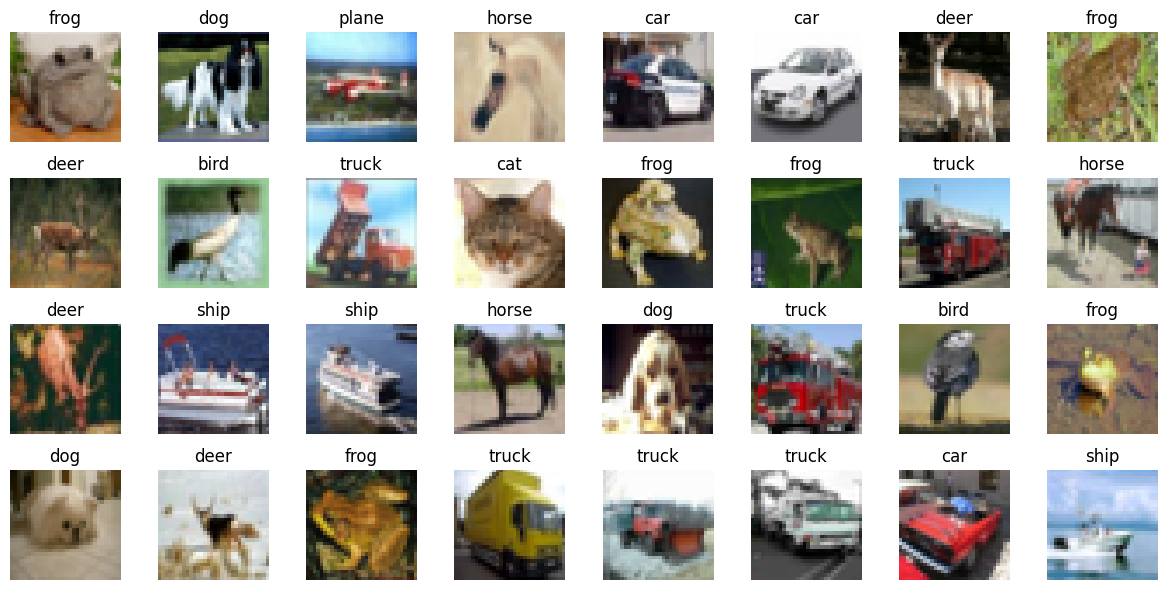

In [5]:
# first batch of images and labels in the first training set
images, labels = next(iter(trainloaders[0]))

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(CLASSES[labels[i]])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()